In [52]:

import numpy as np
import random
import matplotlib.pyplot as plt

## torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


## Torchvision
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset , random_split
import torchvision.models as models



DATASET_PATH = "./data"
random.seed(42)
#Device
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# print("Device:", device)


In [2]:
from files.models import *

#### Data Preparation : Partionning & preprocesing

## **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.


In [3]:
# Transform to normalized Tensors in the range [0,1]

transform = T.Compose([T.Pad(2) #to cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).
                       , T.ToTensor(), T.Normalize((0.5,), (0.5,))])

In [4]:
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=transform)
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=transform)

In [5]:
MNIST_train_dataset, MNIST_test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                Pad(padding=2, fill=0, padding_mode=constant)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

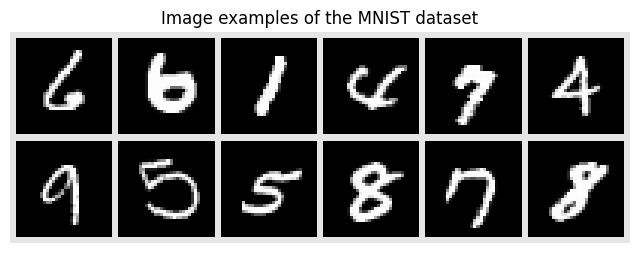

In [6]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [7]:
# use DataLoader to keep applied transformation when download the data..

MNIST_train_loader = torch.utils.data.DataLoader(MNIST_train_dataset, batch_size=64, shuffle=True)
MNIST_test_loader = torch.utils.data.DataLoader(MNIST_test_dataset, batch_size=64, shuffle=False)
# help(MNIST_train_loader)
#check stats :
data_iter = iter(MNIST_train_loader)
images, labels = next(data_iter)

mean = images.mean()
std = images.std()
min_val = images.min()
max_val = images.max()

print(f'Batch Mean: {mean.item()}')
print(f'Batch Std: {std.item()}')
print(f'Batch Min: {min_val.item()}')
print(f'Batch Max: {max_val.item()}')

Batch Mean: -0.7804680466651917
Batch Std: 0.5762251615524292
Batch Min: -1.0
Batch Max: 1.0


In [8]:
train_images, train_labels = next(iter(MNIST_train_loader))
print(train_images.shape) 
print(train_labels.shape) 

torch.Size([64, 1, 32, 32])
torch.Size([64])


#### Baseline Model Setup : extent with limited labeled data

In [9]:
indices = np.random.permutation(len(MNIST_train_dataset))[:100]

train_100= Subset(MNIST_train_dataset, indices)
train_100_loader = DataLoader(train_100, batch_size=10, shuffle=True)

In [10]:
image, label = train_100[0]  
image.shape, label


(torch.Size([1, 32, 32]), 8)

In [11]:
model = Basic_CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
num_epochs = 10
model.train() 
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_100_loader:
        optimizer.zero_grad()          
        outputs = model(images)        
        loss = criterion(outputs, labels) 
        loss.backward()                
        optimizer.step()              
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_100_loader):.4f}")

Epoch [1/10], Loss: 3.1209
Epoch [2/10], Loss: 2.0246
Epoch [3/10], Loss: 1.6912
Epoch [4/10], Loss: 1.2193
Epoch [5/10], Loss: 0.9272
Epoch [6/10], Loss: 0.7110
Epoch [7/10], Loss: 0.5366
Epoch [8/10], Loss: 0.4204
Epoch [9/10], Loss: 0.3738
Epoch [10/10], Loss: 0.2870


In [13]:
model.eval()  
correct = 0
total = 0

with torch.no_grad():
    for images, labels in MNIST_test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set (10K): {100 * correct / total:.2f}%")

Accuracy on the test set (10K): 66.29%


MoCo was implemented on RGB ImageNet data with and ResNet encoder 

* adapting the input layer to handle 28x28 grayscale images (instead of the 224x224 RGB images typically used with ImageNet)

In [14]:
transform_MoCo = T.Compose([
    T.Resize((32, 32)),  
    T.Grayscale(3),      # duplicate channels to simulate RGB
    T.RandomApply([
        T.RandomRotation(10),
        T.RandomAffine(degrees=0, translate=(0.1, 0.1))
    ]),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # std ImageNet normalization
])

train_MoCo = MNIST(root=DATASET_PATH, train=True, download=True, transform=transform_MoCo)
test_MoCo= MNIST(root=DATASET_PATH, train= False, download=True, transform=transform_MoCo)


* modify MoCo loader to handle our data
* configuration (explore light encoder beside resnet(mnist is too simple than imageNet))

In [15]:
batch_size = 128
workers = 4

MoCo_train_loader = DataLoader(train_MoCo, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
MoCo_test_loader = DataLoader(test_MoCo, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)


In [66]:
%ls

__init__.py  __pycache__/ data/        draft.ipynb  files/


In [70]:
import sys
import os

if os.path.abspath('.') not in sys.path:
    sys.path.append(os.path.abspath('.'))

print("Current directory:", os.getcwd())
print("Python path:", sys.path)

from moco.builder import MoCo
from moco.loader import TwoCropsTransform

Current directory: /Users/grace/Desktop/M2/deep_learning/self_supervised_learning
Python path: ['/Users/grace/Desktop/M2/deep_learning/self_supervised_learning', '/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/grace/Library/Python/3.11/lib/python/site-packages', '/opt/homebrew/lib/python3.11/site-packages', '/opt/homebrew/lib/python3.11/site-packages/gpg-1.23.1-py3.11-macosx-12-arm64.egg', '/Users/grace/Desktop/M2', '/Users/grace/Desktop/M2/deep_learning/self_supervised_learning/moco', '/Users/grace/Desktop/M2/deep_learning/moco', '/Users/grace/Desktop/M2/deep_learning/moco/moco', '/Users/grace/Desktop/M2/deep_learning']


In [71]:
print(dir(models))


['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights', 'ConvNeXt_Small_Weights', 'ConvNeXt_Tiny_Weights', 'DenseNet', 'DenseNet121_Weights', 'DenseNet161_Weights', 'DenseNet169_Weights', 'DenseNet201_Weights', 'EfficientNet', 'EfficientNet_B0_Weights', 'EfficientNet_B1_Weights', 'EfficientNet_B2_Weights', 'EfficientNet_B3_Weights', 'EfficientNet_B4_Weights', 'EfficientNet_B5_Weights', 'EfficientNet_B6_Weights', 'EfficientNet_B7_Weights', 'EfficientNet_V2_L_Weights', 'EfficientNet_V2_M_Weights', 'EfficientNet_V2_S_Weights', 'GoogLeNet', 'GoogLeNetOutputs', 'GoogLeNet_Weights', 'Inception3', 'InceptionOutputs', 'Inception_V3_Weights', 'MNASNet', 'MNASNet0_5_Weights', 'MNASNet0_75_Weights', 'MNASNet1_0_Weights', 'MNASNet1_3_Weights', 'MaxVit', 'MaxVit_T_Weights', 'MobileNetV2', 'MobileNetV3', 'MobileNet_V2_Weights', 'MobileNet_V3_Large_Weights', 'MobileNet_V3_Small_Weights', 'RegNet', 'RegNet_X_16GF_Weights', 'RegNet_X_1_6GF_Weights', 'RegNet_X_32GF_

In [72]:
model = MoCo(
    base_encoder=models.resnet18,  
    dim=128,                       
    K=4096,                        
    m=0.99,                        
    T=0.07                         
)
# model = model.cuda()

In [73]:
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0001)

def train(model, data_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for images, _ in data_loader:
            images = images.cuda()
            output, target = model(images)  
            loss = criterion(output, target)  

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

def evaluate(model, data_loader):
    model.eval()
    with torch.no_grad():
        correct = total = 0
        for images, labels in data_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on test images: {100 * correct / total}%')


In [74]:
train(model, MoCo_train_loader, optimizer, epochs=10)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
evaluate(model, MoCo_test_loader)